In [2]:
#mlflow server --port 5000
#sudo kill -9 $(sudo lsof -t -i:5000)
import torch
from train import Trainer
from dataset import DataPreparation
from models import *
from eval import evaluate_model
from sklearn.metrics import f1_score
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [5]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Thiết bị sử dụng (cuda hoặc cpu)
        self.train_dir = "../../dataset/train/"  # Đường dẫn đến dữ liệu huấn luyện
        self.test_dir = '../../dataset/test/'
        self.num_classes = None
        self.class_names = None
        self.batch_size = 16
        self.max_epochs = 10
        self.patience = 3
        self.lr = 0.001
        self.beta1 = 0.95
        self.beta2 = 0.993
        self.model_name = 'mobilenetv3'
        self.name_exp = 'classification'
        self.mlflow = mlflow

In [6]:
# Loss
criterion = nn.CrossEntropyLoss()
# Config
cfg = Config()
data_preparation = DataPreparation(
    cfg = cfg
    )

cfg.mlflow.start_run(run_name=f"{cfg.name_exp}")

Số lượng lớp: 6
Tên lớp: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Ánh xạ từ tên lớp sang chỉ số: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of train:  14034
Number of test:  3000


<ActiveRun: >

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\DAT NGUYEN/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:03<00:00, 6.23MB/s]
epochs:  10%|█         | 1/10 [02:24<21:40, 144.51s/it]

Epoch 1/10 - Train Loss: 0.3663 - Test Loss: 0.2578 - Train F1: 0.8705 - Test F1: 0.9173


epochs:  20%|██        | 2/10 [03:17<12:05, 90.70s/it] 

Epoch 2/10 - Train Loss: 0.2649 - Test Loss: 0.2479 - Train F1: 0.9083 - Test F1: 0.9137


epochs:  30%|███       | 3/10 [04:07<08:24, 72.11s/it]

Epoch 3/10 - Train Loss: 0.2092 - Test Loss: 0.2349 - Train F1: 0.9262 - Test F1: 0.9220


epochs:  40%|████      | 4/10 [05:02<06:31, 65.29s/it]

Epoch 4/10 - Train Loss: 0.1789 - Test Loss: 0.2779 - Train F1: 0.9369 - Test F1: 0.9200


epochs:  50%|█████     | 5/10 [06:01<05:15, 63.03s/it]

Epoch 5/10 - Train Loss: 0.1497 - Test Loss: 0.2868 - Train F1: 0.9471 - Test F1: 0.9193


epochs:  50%|█████     | 5/10 [06:56<06:56, 83.29s/it]


Epoch 6/10 - Train Loss: 0.1382 - Test Loss: 0.2764 - Train F1: 0.9514 - Test F1: 0.9240
Early stopping triggered.
Training finished.


eval: 100%|██████████| 188/188 [00:08<00:00, 22.05it/s]


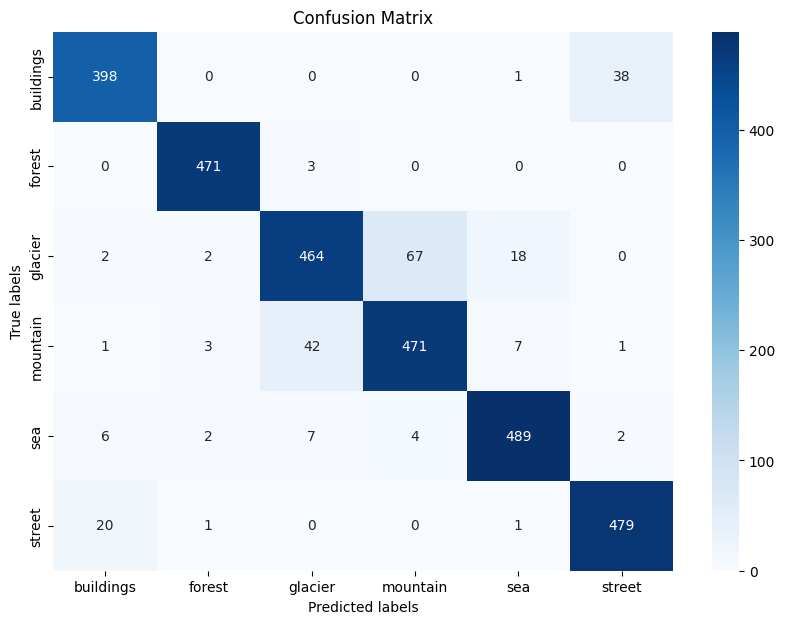

2023/10/23 14:04:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/23 14:04:45 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [7]:

mlflow.log_param("batch_size", cfg.batch_size)
mlflow.log_param("learning_rate", cfg.lr)
mlflow.log_param("beta1", cfg.beta1)
mlflow.log_param("beta2", cfg.beta2)
mlflow.log_param("type_model", cfg.model_name) 


# Create dataloader
data_preparation.create_data_loaders()
trainloader = data_preparation.trainloader
testloader = data_preparation.testloader
cfg.num_classes = data_preparation.num_classes
cfg.class_names = data_preparation.classes_name

# Create Model
if cfg.model_name == 'resnet':
    model = resnet18_frozen(cfg.num_classes)
elif cfg.model_name == 'mobilenetv3':
    model = mobilenetv3_frozen(cfg.num_classes)
elif cfg.model_name == 'efficientnet':
    model = efficientnet_frozen(cfg.num_classes)


# Create Trainer
trainer = Trainer(
    model = model, 
    train_loader=trainloader, 
    test_loader=testloader,
    cfg=cfg
)

optimizer = optim.Adam(model.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

# Training
trainer.train(
    optimizer=optimizer, 
    scheduler=None,
    criterion=criterion
)
best_model = trainer.model_best_loss
all_predictions, all_true_labels = evaluate_model(
    model=best_model, 
    test_dataloader = testloader, 
    device = cfg.device, 
    class_names = data_preparation.classes_name
)

f1 = f1_score(all_true_labels, all_predictions, average='weighted')
mlflow.log_metric("f1_score", f1)
mlflow.pytorch.log_model(best_model, artifact_path="pytorch-model")